<a href="https://colab.research.google.com/github/lhartwig22/419IDEAS/blob/main/Structured_Data_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured data classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Edited by:** lhartwig@hawk.iit.edu<br>
**Date created:** 2020/06/09<br>
**Last modified:** 2022/11/29<br>
**Description:** Binary classification of structured data including numerical and categorical features.

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

## Preparing the data

Let's download the data and load it into a Pandas dataframe:

In [2]:
file_url = "https://github.com/lhartwig22/419IDEAS/raw/main/Compressed%20COPD%20Dataset.csv"
dataframe = pd.read_csv(file_url, encoding='latin-1')

The dataset includes 301 samples with 12 columns per sample (10 features, plus COPD stage):

In [3]:
dataframe.shape

(100, 12)

Here's a preview of a few samples:

In [4]:
dataframe.head()

,ID,AGE,gender,PackHistory,smoking,FEV1%,Diabetes,muscular,hypertension,AtrialFib,IHD,copd
0,1,77,1,60.0,2,0.504167,1,0,0,1,0,3
1,2,79,0,50.0,2,0.660000,1,0,0,1,1,2
2,3,80,0,11.0,2,0.660870,1,0,0,1,0,2
3,4,56,1,60.0,2,0.410000,0,0,1,1,0,4
4,5,65,1,68.0,2,0.370000,0,1,1,0,0,3


The 12th column, "copd", indicates the stage of COPD of the patients as a numerical value.

Let's split the data into a training and validation set:

In [5]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 80 samples for training and 20 for validation


Let's generate `tf.data.Dataset` objects for each dataframe:

In [6]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("copd")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Each `Dataset` yields a tuple `(input, copd)` where `input` is a dictionary of features
and `copd` is the value `0`, `1`, `2`, `3`, or `4`:

In [7]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("COPD Stage:", y)

Input: {'ID': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'AGE': <tf.Tensor: shape=(), dtype=int64, numpy=49>, 'gender': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'PackHistory': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'smoking': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'FEV1%': <tf.Tensor: shape=(), dtype=float64, numpy=0.777777777777778>, 'Diabetes': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'muscular': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'hypertension': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'AtrialFib': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'IHD': <tf.Tensor: shape=(), dtype=int64, numpy=0>}
COPD Stage: tf.Tensor(0, shape=(), dtype=int64)


Let's batch the datasets:

In [8]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

## Feature preprocessing with Keras layers


The following features are categorical features encoded as integers:

- `gender`
- `diabetes`
- `muscular`
- `hypertension`
- `atrialfib`
- `IHD`

We will encode these features using **one-hot encoding**. We have two options
here:

 - Use `CategoryEncoding()`, which requires knowing the range of input values
 and will error on input outside the range.
 - Use `IntegerLookup()` which will build a lookup table for inputs and reserve
 an output index for unkown input values.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a string: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

Finally, the following feature are continuous numerical features:

- `age`
- `packhistory`
- `smoking`
- `FEV1%`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.

Below, we define 3 utility functions to do the operations:

- `encode_numerical_feature` to apply featurewise normalization to numerical features.
- `encode_string_categorical_feature` to first turn string inputs into integer indices,
then one-hot encode these integer indices.
- `encode_integer_categorical_feature` to one-hot encode integer categorical features.

In [9]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Build a model

With this done, we can create our end-to-end model:

In [10]:
# Categorical features encoded as integers
gender = keras.Input(shape=(1,), name="gender", dtype="int64")
smoking = keras.Input(shape=(1,), name="smoking", dtype="int64")
diabetes = keras.Input(shape=(1,), name="Diabetes", dtype="int64")
muscular = keras.Input(shape=(1,), name="muscular", dtype="int64")
hypertension = keras.Input(shape=(1,), name="hypertension", dtype="int64")
atrialFib = keras.Input(shape=(1,), name="AtrialFib", dtype="int64")
IHD = keras.Input(shape=(1,), name="IHD", dtype="int64")

# Numerical features
age = keras.Input(shape=(1,), name="AGE")
packHistory = keras.Input(shape=(1,), name="PackHistory")
FEV1p = keras.Input(shape=(1,), name="FEV1%")

all_inputs = [
    gender,
    age,
    packHistory,
    smoking,
    FEV1p,
    diabetes,
    muscular,
    hypertension,
    atrialFib,
    IHD,
]

# Integer categorical features
gender_encoded = encode_categorical_feature(gender, "gender", train_ds, False)
smoking_endcoded = encode_categorical_feature(smoking, "smoking", train_ds, False)
diabetes_encoded = encode_categorical_feature(diabetes, "Diabetes", train_ds, False)
muscular_encoded = encode_categorical_feature(muscular, "muscular", train_ds, False)
hypertension_encoded = encode_categorical_feature(hypertension, "hypertension", train_ds, False)
atrialFib_encoded = encode_categorical_feature(atrialFib, "AtrialFib", train_ds, False)
IHD_encoded = encode_categorical_feature(IHD, "IHD", train_ds, False)

# Numerical features
age_encoded = encode_numerical_feature(age, "AGE", train_ds)
packHistory_encoded = encode_numerical_feature(packHistory, "PackHistory", train_ds)
FEV1p_encoded = encode_numerical_feature(FEV1p, "FEV1%", train_ds)

all_features = layers.concatenate(
    [
        gender_encoded,
        age_encoded,
        packHistory_encoded,
        smoking_endcoded,
        FEV1p_encoded,
        diabetes_encoded,
        muscular_encoded,
        hypertension_encoded,
        atrialFib_encoded,
        IHD_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Let's visualize our connectivity graph:

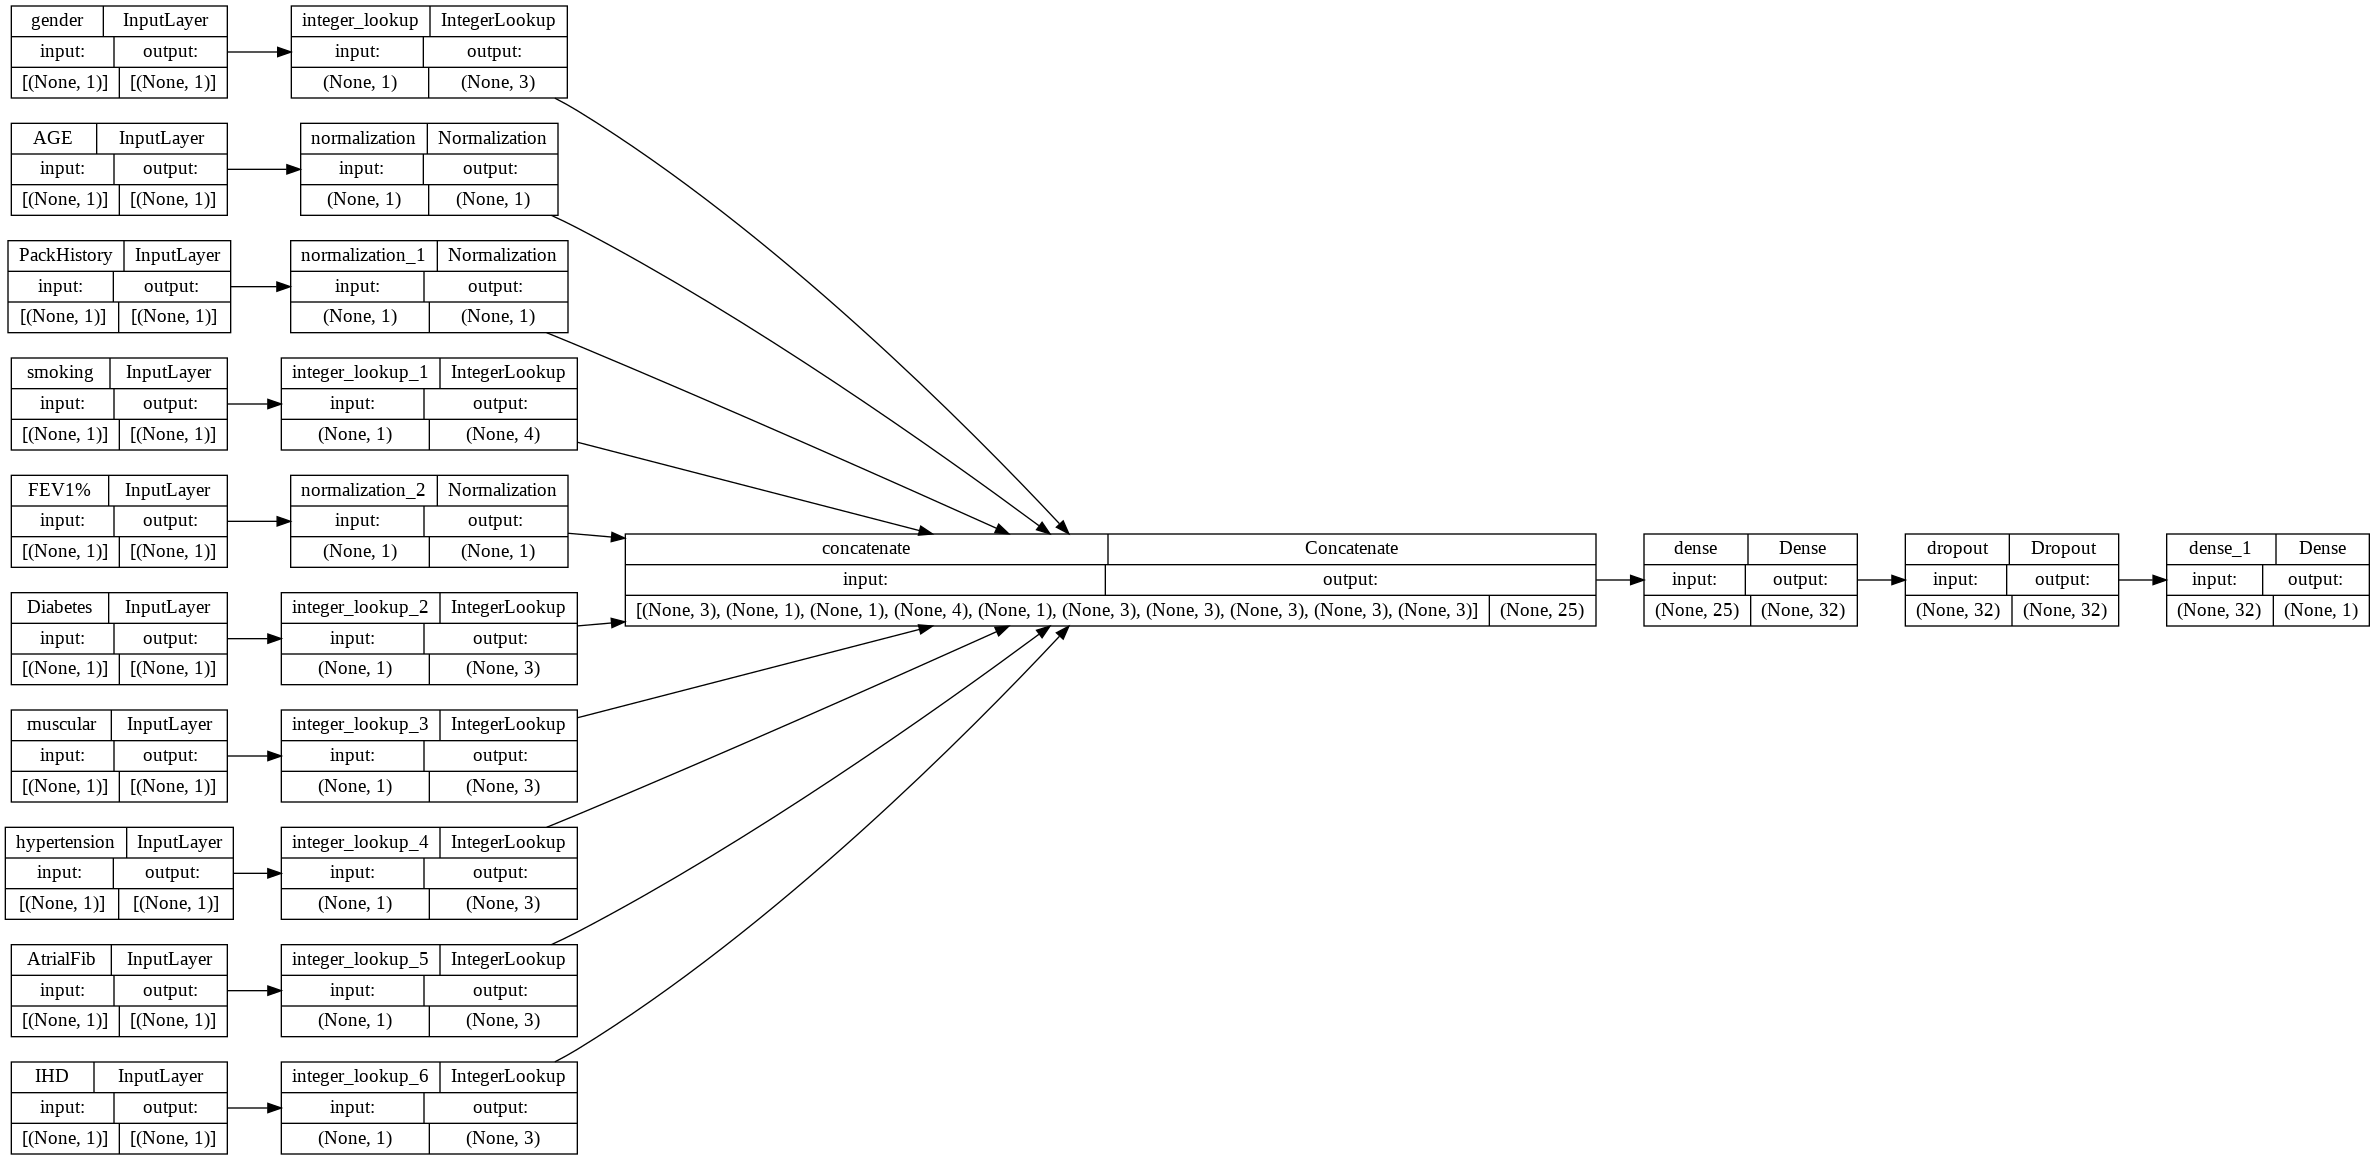

In [11]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model

In [15]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
3/3 [==============================] - 0s 17ms/step - loss: -49.6137 - accuracy: 0.3500 - val_loss: -44.2113 - val_accuracy: 0.1500
Epoch 2/50
3/3 [==============================] - 0s 20ms/step - loss: -52.3856 - accuracy: 0.3125 - val_loss: -44.8229 - val_accuracy: 0.1500
Epoch 3/50
3/3 [==============================] - 0s 26ms/step - loss: -53.2667 - accuracy: 0.3500 - val_loss: -45.4410 - val_accuracy: 0.1500
Epoch 4/50
3/3 [==============================] - 0s 25ms/step - loss: -52.6280 - accuracy: 0.3625 - val_loss: -46.0759 - val_accuracy: 0.1500
Epoch 5/50
3/3 [==============================] - 0s 22ms/step - loss: -51.2984 - accuracy: 0.3500 - val_loss: -46.6997 - val_accuracy: 0.1500
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: -49.8021 - accuracy: 0.3625 - val_loss: -47.3236 - val_accuracy: 0.1500
Epoch 7/50
3/3 [==============================] - 0s 19ms/step - loss: -59.8076 - accuracy: 0.3625 - val_loss: -47.9431 - val_accuracy: 0.1500

## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [13]:
sample = {
    "AGE": 37,
    "gender": 0,
    "PackHistory": 5,
    "smoking": 1,
    "FEV1%": 0.702,
    "Diabetes": 0,
    "muscular": 0,
    "hypertension": 0,
    "AtrialFib": 0,
    "IHD": 0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having COPD, as evaluated by our model." % (100 * predictions[0][0],)
)

1/1 [==============================] - 0s 275ms/step
This particular patient had a 99.9 percent probability of having COPD, as evaluated by our model.
